In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)
from scipy import signal

/tmp/ipykernel_341482/335835994.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
data_dir = 'data_by_days'
NUM_TRAIN_FILES = 1

df = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))])
df.reset_index(drop=True, inplace=True)
df.head(5)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


,timestamp,target,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,...,LIVIK_ask0_price,LIVIK_ask0_qty,LIVIK_ask1_price,LIVIK_ask1_qty,LIVIK_ask2_price,LIVIK_ask2_qty,LIVIK_ask3_price,LIVIK_ask3_qty,LIVIK_ask4_price,LIVIK_ask4_qty
0,1970-01-01 02:00:00.000000000,-1.0,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
1,1970-01-01 02:00:00.499097340,47.5,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
2,1970-01-01 02:00:00.499100368,47.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
3,1970-01-01 02:00:00.499143008,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
4,1970-01-01 02:00:00.502273623,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0


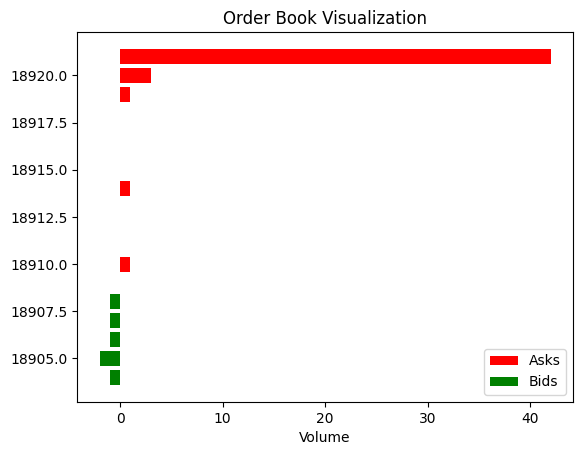

In [3]:
def draw_orderbook(df, number_of_snapshot, instrument='SANHOK'):
    ask_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('price')]
    bid_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('price')]
    ask_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('qty')]
    bid_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('qty')]
    assert number_of_snapshot < len(df)
    ask_prices = df.loc[number_of_snapshot, ask_prices_columns].values
    bid_prices = df.loc[number_of_snapshot, bid_prices_columns].values
    ask_volumes = df.loc[number_of_snapshot, ask_vol_columns].values
    bid_volumes = df.loc[number_of_snapshot, bid_vol_columns].values
    _, ax = plt.subplots()

    ax.barh(ask_prices, ask_volumes, color='red', label='Asks')
    
    ax.barh(bid_prices, -bid_volumes, color='green', label='Bids')

    ax.set_xlabel('Volume')
    ax.set_title('Order Book Visualization')

    ax.legend()
    plt.show()


draw_orderbook(df, 500)

In [4]:
@njit
def get_future_price(ts, values, window):
    price_pointer = 0
    res = np.zeros(ts.size)
    for X_pointer in range(len(ts)):
        while price_pointer + 1 < len(ts) and ts[price_pointer] < ts[X_pointer] + window:
            price_pointer += 1
        res[X_pointer] = values[price_pointer]
    return res

for i in tqdm(range(NUM_TRAIN_FILES)):
    day_df = pd.read_feather(f'{data_dir}/train_{i}.feather')
    ts = ((day_df.timestamp - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    midprice = ((day_df.SANHOK_bid0_price + day_df.SANHOK_ask0_price) / 2).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')
    future_price = get_future_price(ts, midprice, window)
    assert all(day_df['target'] == get_future_price(ts, midprice, window) - midprice)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


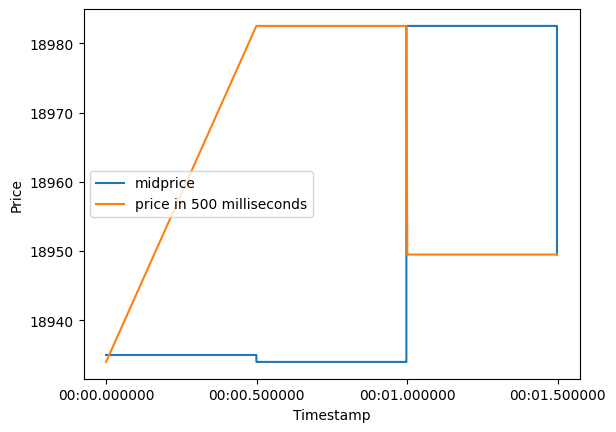

In [5]:
n = 16
_, ax = plt.subplots()
ax.plot(day_df.timestamp[:n], midprice[:n], label='midprice')
ax.plot(day_df.timestamp[:n], future_price[:n], label='price in 500 milliseconds')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

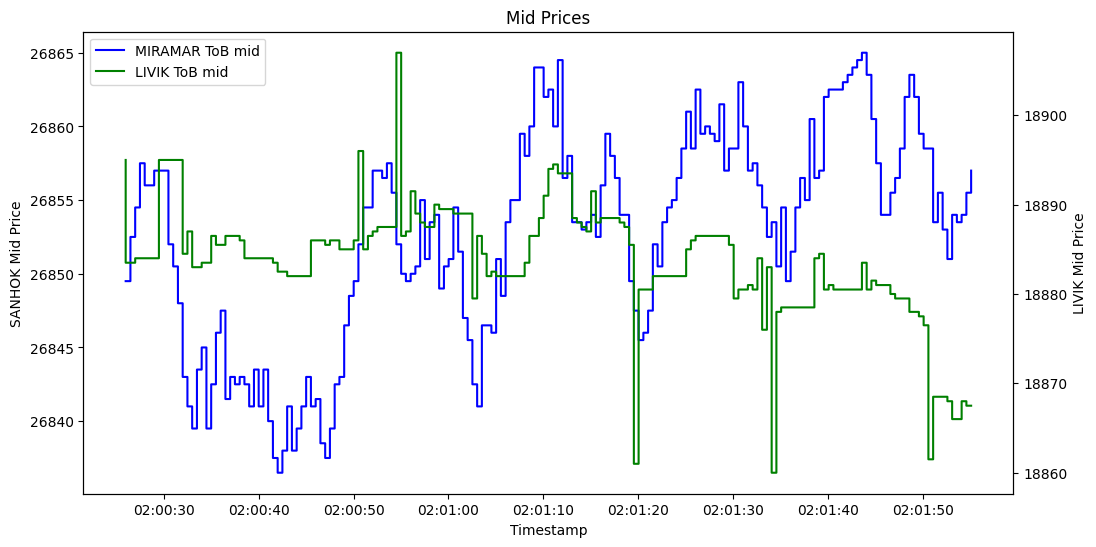

In [6]:
data = df.set_index("timestamp")[0:10000]
instruments = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for i in instruments:
    data[i + "_ToB_mid"] = (data[i + "_bid0_price"] + data[i + "_ask0_price"]) / 2
    
# plot the bid and ask prices over time
ind1 = 300
ind2 = 1300
instrument1 = "MIRAMAR"
instrument2 = "LIVIK"
# create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# plot the bid and ask prices for the first instrument
ax1.plot(data[ind1:ind2].index, data[ind1:ind2][instrument1 + '_ToB_mid'], label= instrument1 +' ToB mid', color='blue')
# ax1.plot(data[ind1:ind2].index, data[ind1:ind2]['MIRAMAR_ask0_price'], label='MIRAMAR Ask', color='blue')

# plot the bid and ask prices for the second instrument on the right y-axis
ax2.plot(data[ind1:ind2].index, data[ind1:ind2][instrument2 + '_ToB_mid'], label=instrument2 + ' ToB mid', color='green')
# ax2.plot(data[ind1:ind2].index, data[ind1:ind2]['LIVIK_ask0_price'], label='LIVIK Ask', color='green')

# set the labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('SANHOK Mid Price')
ax2.set_ylabel('LIVIK Mid Price')
plt.title('Mid Prices')

# add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# display the plot
plt.show()

In [7]:
data_original = data
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Remove the target column
data = data.drop('target', axis=1)

# Convert the timestamp column to datetime format
data.index = pd.to_datetime(data.index)

In [8]:
# Calculate VWAP for the bid prices
bid_order_books = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for order_book in bid_order_books:
    bid_price_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_bid")) & ("price" in col))]
    bid_qty_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_bid")) & ("qty" in col))]
    data[f"{order_book}_bid_vwap"] = (data[bid_price_columns].values * data[bid_qty_columns].values).sum(axis=1) / (data[bid_qty_columns].values).sum(axis=1)
    data[f"{order_book}_bid_size_sum"] = data[bid_qty_columns].sum(axis=1)

# Calculate VWAP for the ask prices
ask_order_books = ["MIRAMAR", "LIVIK", "SANHOK", "ERANGEL", "VIKENDI", "KARAKIN"]
for order_book in ask_order_books:
    ask_price_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_ask")) & ("price" in col))]
    ask_qty_columns = [col for col in data.columns if ((col.startswith(f"{order_book}_ask")) & ("qty" in col))]
    data[f"{order_book}_ask_vwap"] = (data[ask_price_columns].values * data[ask_qty_columns].values).sum(axis=1) / (data[ask_qty_columns].values).sum(axis=1)
    data[f"{order_book}_ask_size_sum"] = data[ask_qty_columns].sum(axis=1)


In [9]:
data

,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,MIRAMAR_bid4_price,MIRAMAR_bid4_qty,...,LIVIK_ask_vwap,LIVIK_ask_size_sum,SANHOK_ask_vwap,SANHOK_ask_size_sum,ERANGEL_ask_vwap,ERANGEL_ask_size_sum,VIKENDI_ask_vwap,VIKENDI_ask_size_sum,KARAKIN_ask_vwap,KARAKIN_ask_size_sum
timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 02:00:00.000000000,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,26780.0,1.0,...,18985.250000,8.0,18951.599609,10.0,31857.800781,25.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499097340,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,26780.0,1.0,...,18985.250000,8.0,18951.599609,10.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499100368,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18951.599609,10.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.499143008,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18949.064453,31.0,31858.554688,27.0,26792.691406,13.0,31604.000000,19.0
1970-01-01 02:00:00.502273623,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,26800.0,13.0,...,18985.250000,8.0,18949.064453,31.0,31858.554688,27.0,26792.691406,13.0,31578.750000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 02:15:17.472128647,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31656.357422,14.0
1970-01-01 02:15:17.474144111,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31672.666016,18.0
1970-01-01 02:15:17.474150133,26721.0,5.0,26720.0,1.0,26719.0,5.0,26718.0,1.0,26716.0,1.0,...,18720.000000,6.0,18751.384766,13.0,31903.064453,31.0,26716.562500,16.0,31672.666016,18.0


In [67]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import A2C

class TradingEnv(gym.Env):
    def __init__(self, data, transaction_cost):
        self.transaction_cost = transaction_cost
        self.total_pnl = 0.0
        super(TradingEnv, self).__init__()
        self.data = data
        self.trade_history = []  # Store each action and the corresponding total profit

        # Define action and observation space
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.data.shape[1],))

        self.current_step = 0
        self.position = 0
        self.trade_fee = transaction_cost

    def step(self, action):
        self.current_step += 1
        transaction_cost = 0
        pnl = 0

        bid_idx = 0  # Index for the bid price in the data
        ask_idx = 10  # Index for the ask price in the data

        # Apply action
        if action == 0:  # Buy
            if self.position <= 0:  
                transaction_cost = abs(self.position - 1) * self.trade_fee
                pnl = -transaction_cost  # Immediately incur transaction cost
                self.position = 1
                self.opening_trade_price = self.data.iloc[self.current_step, ask_idx]
            # Mark to Market
            pnl += (self.data.iloc[self.current_step, bid_idx] - self.opening_trade_price)

        elif action == 1:  # Sell
            if self.position >= 0:  
                transaction_cost = abs(self.position + 1) * self.trade_fee
                pnl = -transaction_cost  # Immediately incur transaction cost
                self.position = -1
                self.opening_trade_price = self.data.iloc[self.current_step, bid_idx]
            # Mark to Market
            pnl += (self.opening_trade_price - self.data.iloc[self.current_step, ask_idx])
        
        self.total_pnl += pnl

        # Check if we're at the end of the dataframe
        done = self.current_step == len(self.data)-1

        # If we're at the end of the data, close position
        if done and self.position != 0:
            transaction_cost += self.trade_fee
            if self.position == 1:
                pnl += (self.data.iloc[self.current_step, bid_idx] - self.opening_trade_price)
            elif self.position == -1:
                pnl += (self.opening_trade_price - self.data.iloc[self.current_step, ask_idx])
            self.position = 0

        # Force the position to zero after 50 steps
        elif self.current_step % 50 == 0 and self.position != 0:
            transaction_cost += self.trade_fee
            if self.position == 1:
                pnl += (self.data.iloc[self.current_step, bid_idx] - self.opening_trade_price)
            elif self.position == -1:
                pnl += (self.opening_trade_price - self.data.iloc[self.current_step, ask_idx])
            self.position = 0

        # Penalize losses more than profits
        if pnl < 0:
            reward = pnl * 2
        else:
            reward = pnl

        self.trade_history.append((self.data.index[self.current_step], action, reward, self.total_pnl))
        
        return self.data.iloc[self.current_step, :], reward, done, {}


    def reset(self):
        self.current_step = 0
        self.position = 0
        return self.data.iloc[self.current_step, :]

    def render(self):
        pass


In [68]:
# Initialize the trading environment
transaction_cost = 0.00001
env = TradingEnv(data, transaction_cost)

# Initialize the agent
model = A2C('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 774      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.0522  |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 9.65e-06 |
|    value_loss         | 1.74e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 762      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.0362  |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates    

-------------------------------------
| time/                 |           |
|    fps                | 767       |
|    iterations         | 1700      |
|    time_elapsed       | 11        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -0.0043   |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -1.46e-09 |
|    value_loss         | 1.03e-11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 769       |
|    iterations         | 1800      |
|    time_elapsed       | 11        |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -0.0043   |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1799      |
|    policy_loss        | -7.77e-08 |
|    value_l

In [69]:
# Simulate trading
obs = env.reset()
for i in range(len(data)):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break
        
trade_df = pd.DataFrame(env.trade_history, columns=['Timestamp', 'Action', 'Reward', 'TotalProfit'])
buy_signals = trade_df[trade_df['Action'] == 0]
sell_signals = trade_df[trade_df['Action'] == 1]

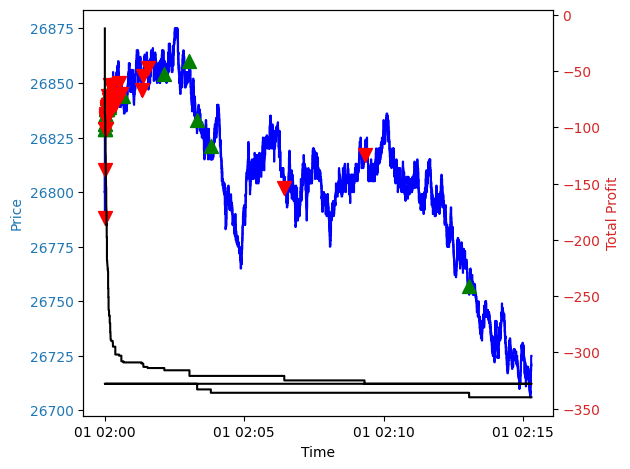

In [70]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
# Make the y-axis label and tick labels match the line color.
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(data.index, data['MIRAMAR_bid0_price'], color='blue', zorder = 1)
ax1.plot(data.index, data['MIRAMAR_ask0_price'], color='blue', zorder = 1)
ax1.scatter(buy_signals['Timestamp'], data.loc[buy_signals['Timestamp'], 'MIRAMAR_ask0_price'], color='green', marker='^', s = 100)
ax1.scatter(sell_signals['Timestamp'], data.loc[sell_signals['Timestamp'], 'MIRAMAR_bid0_price'], color='red', marker='v', s = 100)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
# We already handled the x-label with ax1
ax2.set_ylabel('Total Profit', color=color)
ax2.plot(trade_df['Timestamp'], trade_df['TotalProfit'], color='black')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [72]:
# trade_df["Timestamp"].plot()